# Data EDA
### Questions: to ask: 
- Where are the segmentations masks or are we supposed to always use the same?

### Minimum viable product (passing grade):Implementing, Training, and Evaluating the IVAE Model on Brain MRI Data

1. **Implementing a Dataset Class**
    - Check Class DementiaPatientDataset: How can we implement a dataset class that loads 2D slices of the brain MRIs (e.g., the middle slice) across a given axis (e.g., the coronal axis), along with the corresponding labels (age, sex, dementia status)?

2. **Model Architectures**
    - How can we implement the encoder, decoder, and prior_encoder model architectures?
    - How can we ensure that the encoder and decoder are powerful enough to sufficiently model the images (e.g., based on the ResNet architectures)?
    - (Example code for ResNet encoders and decoders: [ResNet Components](https://github.com/LightningUniverse/lightning-bolts/blob/master/src/pl_bolts/models/autoencoders/components.py))
    - Ideas: Keras seems to work too: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-variational-autoencoder-with-keras.md

3. **Measuring Training Progress**
    - How can we implement essential ways of measuring training progress?
        - How should we log each loss and sub-loss (e.g., `train/loss`, `val/loss`, `train/reconstruction_loss`, `train/kld_loss`, etc.)?
        - How can we plot the reconstructions of a few validation samples across training (ensuring the same samples are selected for each epoch)?
        - How can we log all these measures to a tool like Weights & Biases (or similar)?

4. **Cross-Validation and Hyperparameter Tuning**
    - How can we implement subject-out cross-validation?
    - How can we perform a simple hyperparameter grid search across 5 folds to find the highest possible weight for the Kullback-Leibler (KL) divergence loss, where the model still achieves reasonable reconstruction?

In [1]:
import os
import torch
import nibabel as nib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from matplotlib.widgets import Slider

In [4]:
subject_root = Path('../df.csv')
assert subject_root.exists()

print("Current working directory:", os.getcwd())

Current working directory: /dhc/home/arman.beykmohammadi/AMLS/ml-seminar-brain-mri-dementia-ivae/notebooks


In [2]:
dementia_df = pd.read_csv('../df.csv')
dementia_df

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,...,RID,CDGLOBAL,CDGLOBAL_MAX,path,MAGSTRENGTH,IMAGEUID,mmse,hippo,ventricles,CI
0,7025,011_S_0002,CN,M,74,1,MRI,MPRAGE,Original,2005-08-26,...,2,0.0,0.5,/dhc/groups/fglippert/adni_t1_mprage/011_S_000...,1.494,7025,28.0,8835.626,40668.538,0
1,128593,023_S_0030,MCI,F,83,8,MRI,MPRAGE,Original,2008-11-26,...,30,1.0,1.0,/dhc/groups/fglippert/adni_t1_mprage/023_S_003...,1.500,128593,28.0,8445.579,33791.786,1
2,26207,023_S_0030,MCI,F,81,4,MRI,MPRAGE,Original,2006-10-12,...,30,1.0,1.0,/dhc/groups/fglippert/adni_t1_mprage/023_S_003...,3.000,26207,24.0,9467.639,31613.893,1
3,26200,023_S_0030,MCI,F,81,4,MRI,MPRAGE,Original,2006-10-12,...,30,1.0,1.0,/dhc/groups/fglippert/adni_t1_mprage/023_S_003...,1.494,26200,24.0,9501.195,29837.204,1
4,82080,023_S_0030,MCI,F,82,6,MRI,MPRAGE,Original,2007-11-13,...,30,1.0,1.0,/dhc/groups/fglippert/adni_t1_mprage/023_S_003...,3.000,82080,19.0,8953.956,32441.894,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12786,1319217,168_S_6875,MCI,M,73,1,MRI,Accelerated Sagittal MPRAGE,Original,2020-06-29,...,6875,0.5,0.5,/dhc/groups/fglippert/adni_t1_mprage/168_S_687...,3.000,1319217,28.0,10622.910,26361.624,1
12787,1330894,305_S_6881,AD,F,62,1,MRI,Sagittal 3D Accelerated MPRAGE,Original,2020-08-24,...,6881,0.5,0.5,/dhc/groups/fglippert/adni_t1_mprage/305_S_688...,3.000,1330894,NaN,9288.882,34461.515,1
12788,1335565,036_S_6885,MCI,M,72,1,MRI,Accelerated Sagittal MPRAGE,Original,2020-09-11,...,6885,0.5,0.5,/dhc/groups/fglippert/adni_t1_mprage/036_S_688...,3.000,1335565,28.0,7059.118,40483.817,1
12789,1406556,168_S_6902,MCI,M,83,1,MRI,Accelerated Sagittal MPRAGE,Original,2021-02-04,...,6902,0.5,0.5,/dhc/groups/fglippert/adni_t1_mprage/168_S_690...,3.000,1406556,NaN,8265.934,40142.316,1


In [ ]:
""" Step 1: Load the dataset """
# Renamed the slack df to dementia_df for better readability and added to data folder
dementia_df = pd.read_csv('../data/dementia_df.csv')
# print(dementia_df.columns)

# print(dementia_df.path.iloc[0])
# print(dementia_df.path.iloc[1])

# Create a subset of the dementia_df
# subset #'002_S_0413', '002_S_0559', #002_S_0295, #S88111
test_ids = ['018_S_0450']

#
test_df = dementia_df[dementia_df['Subject'].isin(test_ids)]
# Test = dementia_dat.columns[['Subject','Group', 'path']]
test_df = test_df[['Subject', 'Group', 'path', 'Age', 'Sex']]

# For local path  the old root path and the new root path
"""
old_path = 'dhc/groups/fglippert/adni_t1_mprage'
new_path = 'AML/DVA4D'

# Apply replacement directly to the 'path' column in the DataFrame
test_df['path'] = test_df['path'].str.replace(old_path, new_path, regex=False)

# Display modified DataFrame
dementia_df
"""
test_df

,Subject,Group,path,Age,Sex
12272,018_S_0450,MCI,/dhc/groups/fglippert/adni_t1_mprage/018_S_045...,71,M
12273,018_S_0450,MCI,/dhc/groups/fglippert/adni_t1_mprage/018_S_045...,72,M
12274,018_S_0450,MCI,/dhc/groups/fglippert/adni_t1_mprage/018_S_045...,72,M
12275,018_S_0450,MCI,/dhc/groups/fglippert/adni_t1_mprage/018_S_045...,71,M
12276,018_S_0450,MCI,/dhc/groups/fglippert/adni_t1_mprage/018_S_045...,72,M
12277,018_S_0450,MCI,/dhc/groups/fglippert/adni_t1_mprage/018_S_045...,72,M


In [ ]:
def collate_fn(batch):
    max_visits = max(patient_data.shape[0] for patient_data, _ in batch)

    padded_images = []
    padded_labels = []

    for patient_data, patient_labels in batch:
        # Ensure non-negative
        padding_images = max(0, max_visits - patient_data.shape[0])
        padded_images.append(
            torch.cat([patient_data, torch.zeros(
                padding_images, *patient_data.shape[1:])], dim=0)
        )
        padded_patient_labels = patient_labels + [None] * padding_images
        padded_labels.append(padded_patient_labels)

    return torch.stack(padded_images), padded_labels

In [ ]:
"""
Task 1: Implementing a dataset class, which loads 2D slices of the brain MRIs (e.g., 
the middle slice) across a given axis (e.g., the coronal axis), along with the 
corresponding labels (age, sex, dementia status)

"""


class DementiaPatientDataset(Dataset):
    def __init__(self, dataframe, axis="coronal", max_visits=None, transform=None):
        self.axis = axis
        self.transform = transform
        self.patient_data = defaultdict(list)
        for _, row in dataframe.iterrows():
            self.patient_data[row['Subject']].append(row)

        # Sort visits for each patient by visit date
        for subject in self.patient_data:
            self.patient_data[subject] = sorted(
                self.patient_data[subject], key=lambda x: x['Visit']
            )

        # Mapping for the Group column
        self.group_mapping = {
            "CN": 0,      # Cognitively Normal
            "MCI": 0,     # Mild Cognitive Impairment
            "EMCI": 1,    # Early Mild Cognitive Impairment
            "LMCI": 1,    # Late Mild Cognitive Impairment
            "AD": 1,      # Alzheimer's Disease
            "SMC": 1,     # Subjective Memory Complaints
            "Patient": 2  # Generic patient
        }

        self.max_visits = max_visits or max(
            len(visits) for visits in self.patient_data.values())
        self.patients = list(self.patient_data.keys())

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_visits = self.patient_data[patient_id]

        images = []
        labels = []

        for visit in patient_visits[:self.max_visits]:  # Truncate to max_visits
            image_path = visit['path']
            img = nib.load(image_path).get_fdata()

            # Extract the middle slice
            if self.axis == "coronal":
                slice_idx = img.shape[1] // 2
                img_slice = img[:, slice_idx, :]
            elif self.axis == "sagittal":
                slice_idx = img.shape[0] // 2
                img_slice = img[slice_idx, :, :]
            elif self.axis == "axial":
                slice_idx = img.shape[2] // 2
                img_slice = img[:, :, slice_idx]

            # Normalize image
            img_slice = (img_slice - img_slice.min()) / \
                (img_slice.max() - img_slice.min())

            if self.transform:
                img_slice = self.transform(img_slice)

            images.append(torch.tensor(
                img_slice, dtype=torch.float32).unsqueeze(0))

            # Map 'Group' to a numeric value
            dementia_status = self.group_mapping[visit['Group']]
            labels.append({
                'age': torch.tensor(visit['Age'], dtype=torch.float32),
                'sex': torch.tensor(1 if visit['Sex'] == 'F' else 0, dtype=torch.long),
                'dementia_status': torch.tensor(dementia_status, dtype=torch.long)
            })

        # Calculate padding
        # Ensure padding is non-negative
        padding_images = max(0, self.max_visits - len(images))
        images += [torch.zeros_like(images[0])] * padding_images
        labels += [None] * padding_images

        return torch.stack(images), labels

In [ ]:
dataset = DementiaPatientDataset(
    dataframe=dementia_df, axis="coronal", max_visits=10)
data_loader = DataLoader(dataset, batch_size=8,
                         shuffle=True, collate_fn=collate_fn)

# Test DataLoader
for idx, (batch_images, batch_labels) in enumerate(data_loader):
    print(f"Batch {idx + 1}")
    print(f"Batch image shape: {batch_images.shape}")
    print(f"Batch labels: {batch_labels}")
    break

Batch 1
Batch image shape: torch.Size([8, 10, 1, 182, 182])
Batch labels: [[{'age': tensor(85.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(85.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(85.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(85.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(85.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(85.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(86.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(86.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(87.), 'sex': tensor(0), 'dementia_status': tensor(0)}, {'age': tensor(87.), 'sex': tensor(0), 'dementia_status': tensor(0)}], [{'age': tensor(83.), 'sex': tensor(0), 'dementia_status': tensor(1)}, {'age': tensor(83.), 'sex': tensor(0), 'dementia_status': tensor(1)}, None, None, None, None, None, None, None, None], [{'age': tensor(72.), 'sex': tens

In [ ]:
def visualize_patient_data(images, labels, patient_id=None):
    images = images.squeeze(1)  # Shape: (visits, H, W)
    num_visits = len(labels)

    # Create a figure with subplots for each visit
    fig, axes = plt.subplots(1, num_visits, figsize=(15, 5))
    if num_visits == 1:
        axes = [axes]  # Ensure axes is iterable for a single visit

    for i, ax in enumerate(axes):
        ax.imshow(images[i].numpy(), cmap="gray")
        ax.axis("off")

        metadata = labels[i]
        if metadata:
            text = (
                f"Age: {metadata['age'].item()}\n"
                f"Sex: {'Female' if metadata['sex'].item() == 1 else 'Male'}\n"
                f"Dementia: {metadata['dementia_status'].item()}"
            )
        else:
            text = "No Data"
        ax.set_title(text, fontsize=10)

    if patient_id:
        plt.suptitle(f"Patient ID: {patient_id}", fontsize=16)

    plt.tight_layout()
    plt.show()

In [ ]:
patient_images, patient_labels = dataset[1]  # switch patient index
patient_id = dataset.patients[1]


# Uncomment to see pictures with annotated results
# visualize_patient_data(patient_images, patient_labels, patient_id=patient_id)

Resolved path: /dhc/groups/fglippert/adni_t1_mprage/002_S_0295/MPRAGE/2012-05-10_15_44_50.0/S150055/T1toMNInonlin.nii.gz


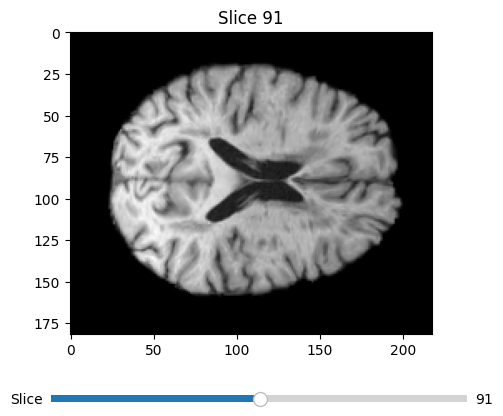

In [ ]:
# Define the path using Path for compatibility
nifti_path = Path(
    '/dhc/groups/fglippert/adni_t1_mprage/002_S_0295/MPRAGE/2012-05-10_15_44_50.0/S150055/T1toMNInonlin.nii.gz').resolve()
print("Resolved path:", nifti_path)

if not nifti_path.exists():
    raise FileNotFoundError(f"The file was not found at: {nifti_path}")

# Load the NIfTI image (compressed .nii.gz format)
# Convert Path to string if nibabel requires it
nifti_img = nib.load(str(nifti_path))
image_data = nifti_img.get_fdata()

# Check if the image is 3D
if len(image_data.shape) != 3:
    raise ValueError("The NIfTI image is not 3D. Please provide a 3D image.")

# Initial setup for the figure and axes
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)
slice_index = image_data.shape[2] // 2  # Start with the middle slice

# Display the initial slice
slice_image = ax.imshow(image_data[:, :, slice_index], cmap="gray")
ax.set_title(f"Slice {slice_index}")

# Slider setup
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor="lightgray")
slice_slider = Slider(ax_slider, "Slice", 0,
                      image_data.shape[2] - 1, valinit=slice_index, valstep=1)

# Update function for the slider


def update(val):
    slice_idx = int(slice_slider.val)
    slice_image.set_data(image_data[:, :, slice_idx])
    ax.set_title(f"Slice {slice_idx}")
    fig.canvas.draw_idle()


# Connect the slider to the update function
slice_slider.on_changed(update)

plt.show()

In [10]:
# metadata
header = nifti_img.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.5:9e026117'
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-1.  0.  0